# Exponential smoothing

用`指数平滑`来重新演示`pmdarima-year.ipynb`

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import pickle

## 加载数据

In [3]:
with open("./data/pmdarima-year.pkl","rb") as f:
    df = pickle.load(f)
df

,Values
Year,
2008-01-01,93.34492
2009-01-01,92.97375
2010-01-01,92.26746
2011-01-01,91.78908
2013-01-01,90.29342
2014-01-01,92.34969
2016-01-01,86.21557
2017-01-01,83.15323
2018-01-01,81.97565


## Exponential smoothing

$\hat{y}_{t}=\alpha \cdot y_{t}+(1-\alpha) \cdot \hat{y}_{t-1}$

由于`简单指数平滑`只能预测一期，后面的预测都和预测的第一期数值一样，这里就当成玩玩,预测得看`double`或`triple`

In [4]:
def exponential_smoothing(series,alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
        pred_n - predict n values
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series, alpha), label="Alpha {}".format(alpha)
            )
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True);

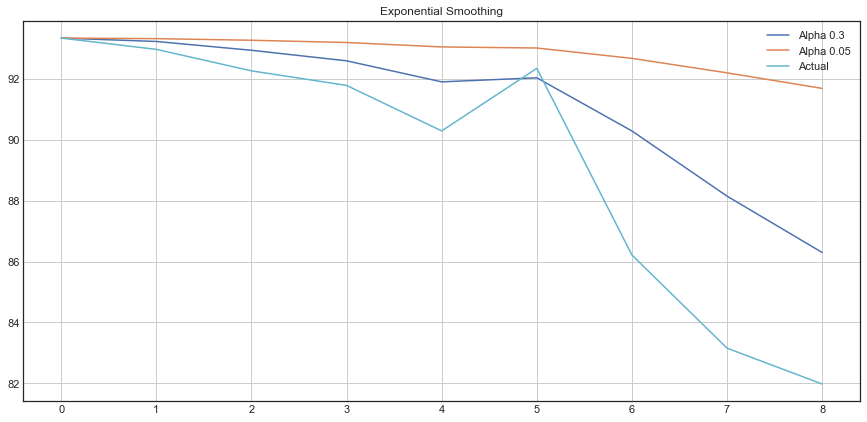

In [5]:
plotExponentialSmoothing(df["Values"], [0.3, 0.05])

## Double exponential smoothing

$$
\begin{array}{c}
\ell_{x} = \alpha y_{x}+(1-\alpha)\left(\ell_{x-1}+b_{x-1}\right) \\
b_{x} = \beta\left(\ell_{x}-\ell_{x-1}\right)+(1-\beta) b_{x-1} \\
\hat{y}_{x+1} = \ell_{x}+b_{x}
\end{array}
$$

`霍特线性趋势模型`,适用条件: `线性趋势，不含季节成分`, 与之类似的`ARIMA`模型: $ARIMA (0,2,2)$

In [7]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

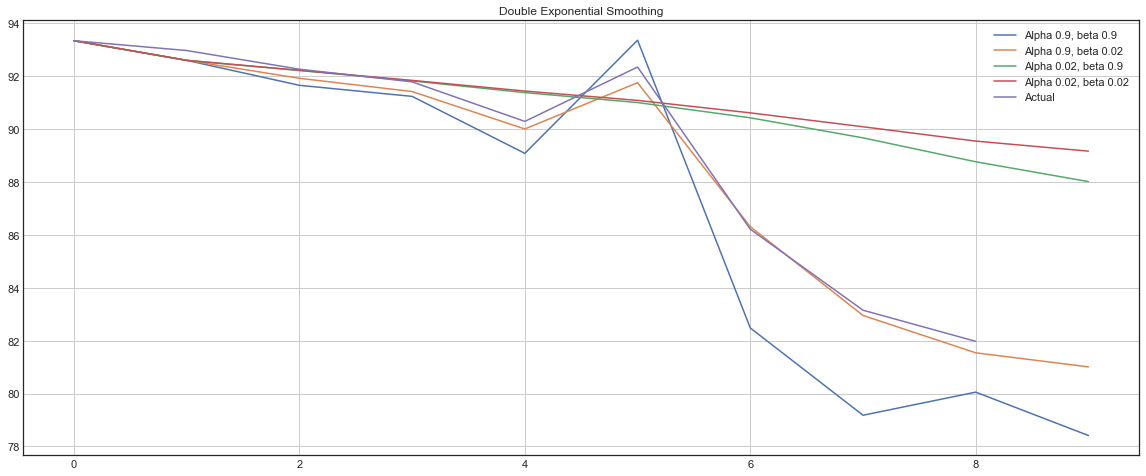

In [8]:
plotDoubleExponentialSmoothing(df["Values"], alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Triple exponential smoothing a.k.a. Holt-Winters


$$
\begin{array}{c}
\ell_{x}=\alpha\left(y_{x}-s_{x-L}\right)+(1-\alpha)\left(\ell_{x-1}+b_{x-1}\right) \\
b_{x}=\beta\left(\ell_{x}-\ell_{x-1}\right)+(1-\beta) b_{x-1} \\
s_{x}=\gamma\left(y_{x}-\ell_{x}\right)+(1-\gamma) s_{x-L} \\
\hat{y}_{x+m}=\ell_{x}+m b_{x}+s_{x-L+1+(m-1) \bmod L}
\end{array}
$$

`温特加法模型`,适用于`含有线性趋势和稳定的季节成分`,与之类似的`ARIMA`模型:$SARIMA (0,1,0) \times (0,1,1)_{s}$

In [22]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize  # for function minimization

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
# 这里就必须导入其它包含季节性的数据了
ads = pd.read_csv("./data/ads.csv",index_col=["Time"],parse_dates=["Time"])
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [20]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])



def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))


def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

In [18]:
%%time
data = ads.Ads[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_log_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

0.11676236693712227 0.0026881337430822994 0.055312622299154346
Wall time: 1.08 s


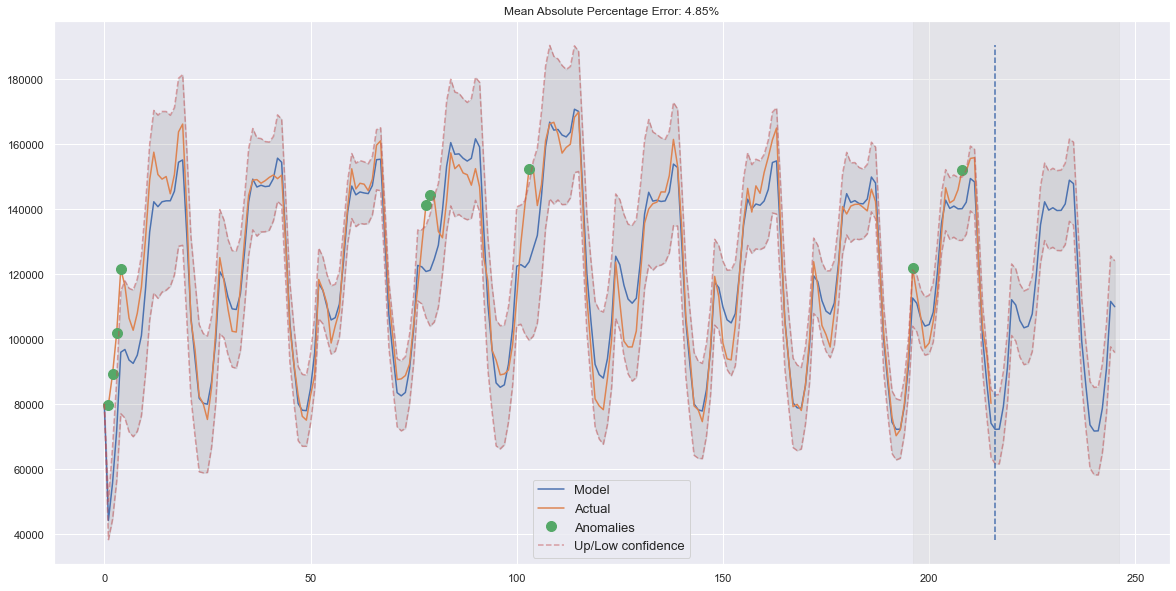

In [24]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)